In [2]:
import cStringIO
from PIL import Image
from sklearn.base import BaseEstimator, TransformerMixin

IMAGE_SHAPE = 128, 128
IMAGE_ARRAY_SIZE = IMAGE_SHAPE[0] * IMAGE_SHAPE[1]

def ela_from_image(file_path, quality=95):
    source_image = Image.open(file_path)
    string_io = cStringIO.StringIO()
    source_image = source_image.resize(IMAGE_SIZE)
    source_image.save(string_io, 'JPEG', quality=quality)
    output_image_io = Image.open(string_io)
    output_image = Image.new('RGB', source_image.size)
    output_image.putdata(map(generator.calculate,
                             source_image.getdata(),
                             output_image_io.getdata()))
    output_image = output_image.convert('L')
    return np.r_[output_image].reshape(-1)

class ELAGenerator():
    def __init__(self, trigger=10, enhance=20, coloronly=False):
        self.trigger = trigger
        self.enhance = enhance
        self.coloronly = coloronly

    def calculate(self, pixelA, pixelB):
        pixelDiff = map(lambda x, y: abs(x - y), pixelA, pixelB)
        if sum(pixelDiff) > self.trigger and (not self.coloronly or pixelDiff[0] != pixelDiff[1] or pixelDiff[0] != pixelDiff[2]):
            return tuple([x * self.enhance for x in pixelDiff])
        else:
            return 0, 0, 0

class ELATransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        ela_X = np.empty((len(X), IMAGE_ARRAY_SIZE))
        for index, file_name in enumerate(X):
            print(index)
            ela_X[index] = ela_from_image(file_name)
        return ela_X



generator = ELAGenerator(trigger=1, enhance=50)

In [3]:
from imread import imread
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
from sklearn import cross_validation
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

IMAGE_SHAPE = 128, 128
IMAGE_ARRAY_SIZE = IMAGE_SHAPE[0] * IMAGE_SHAPE[1]

def read_image(path):
    file = imread(path, as_grey=True)
    file = scipy.misc.imresize(file, IMAGE_SHAPE). \
                      reshape(IMAGE_ARRAY_SIZE)
    return file

def image_files_in_folder(folder):
    all_files = os.listdir(folder)
    return [file for file in all_files if file.endswith('.jpg')]

def load_images(folder, n_files=None):
    image_files = image_files_in_folder(folder)
    if n_files:
        image_files = np.random.choice(image_files_in_folder(folder), n_files)
    images = np.empty((len(image_files), IMAGE_ARRAY_SIZE),
                      dtype=np.float32)
    for i, file_name in enumerate(image_files):
        try:
            images[i] = read_image('/'.join([folder, file_name]))
        except RuntimeError:
            print(i, file_name)
        print(i, images[i].min(), images[i].max())
    return images

def plot_roc_curve(model, X, y):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y, model.predict(X))
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate,
             true_positive_rate,
             'blue',
             label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    print(model.score(X, y))
    print(false_positive_rate, true_positive_rate)

np.random.seed(0)

In [ ]:
psed_images = np.concatenate((
        load_images('../data/psed-reddit-ela', 600),
        load_images('../data/psed-by-email-ela', 600)))
nonpsed_images = load_images('non-psed-ela', 999)
X = np.concatenate((psed_images,
                    nonpsed_images))
y = np.concatenate((np.repeat(1, len(psed_images)),
                    np.repeat(0, len(nonpsed_images))))
np.save('../data/ela_x.npy', X)
np.save('../data/ela_y.npy', y)

In [85]:
X = np.load('../data/ela_x.npy')
y = np.load('../data/ela_y.npy')
X_train, X_test, y_train, y_test = \
    cross_validation.train_test_split(X, y, random_state=0, train_size=.8)

standardizer = StandardScaler()
X_train_std = standardizer.fit_transform(X_train)
X_test_std = standardizer.fit_transform(X_test)

## Random Forest

In [88]:
# hyperparameters = [{
#         'criterion': ['entropy', 'gini'],
#         'max_features': [None, 'auto', 'sqrt', 'log2'],
#         'n_estimators': [3, 5, 10, 20, 30, 100, 500],
# }]
# grid_random_forest = \
#     GridSearchCV(RandomForestClassifier(random_state=0),
#                  param_grid=hyperparameters,
#                  n_jobs=-1,
#                  verbose=True)
# grid_random_forest.fit(X_train, y_train)
# grid_random_forest = grid_random_forest.best_estimator_
# print(grid_random_forest)
# grid_random_forest.score(X_test, y_test)

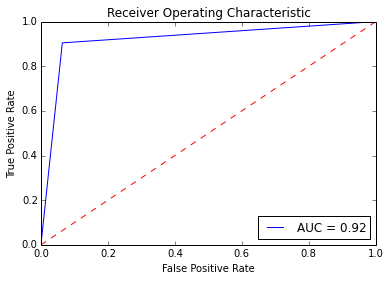

0.918181818182
(array([ 0.        ,  0.06382979,  1.        ]), array([ 0.       ,  0.9047619,  1.       ]))


In [89]:
grid_random_forest = \
    RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=8,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
grid_random_forest.fit(X_train, y_train)
plot_roc_curve(grid_random_forest, X_test, y_test)

## SVC

In [ ]:
# hyperparameters = [
#   {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
#   {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
#  ]
# grid_svc = GridSearchCV(SVC(random_state=0),
#                         param_grid=hyperparameters,
#                         verbose=True)
# grid_svc.fit(X_train, y_train)
# grid_svc = grid_svc.best_estimator_
# print(grid_svc)
# grid_svc.score(X_test, y_test)

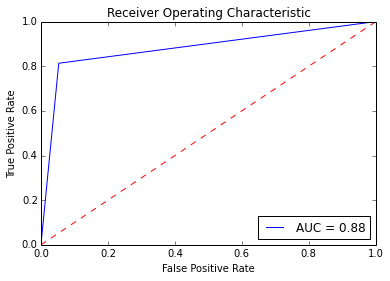

0.870454545455
(array([ 0.        ,  0.05319149,  1.        ]), array([ 0.        ,  0.81349206,  1.        ]))


In [115]:
grid_svc = \
    SVC(C=1,
        gamma='auto',
        kernel='linear',
        probability=True,
        random_state=0)
grid_svc.fit(X_train, y_train)
plot_roc_curve(grid_svc, X_test, y_test)

## Stochastic Gradient Descent

In [ ]:
# hyperparameters = [{
#         'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
#         'penalty': ['none', 'l2', 'l1', 'elasticnet'],
# }]
# grid_sgd = GridSearchCV(SGDClassifier(n_jobs=-1, random_state=0),
#                         param_grid=hyperparameters,
#                         verbose=True)
# grid_sgd.fit(X_train, y_train)
# grid_sgd = grid_sgd.best_estimator_
# print(grid_sgd)
# grid_sgd.score(X_test, y_test)

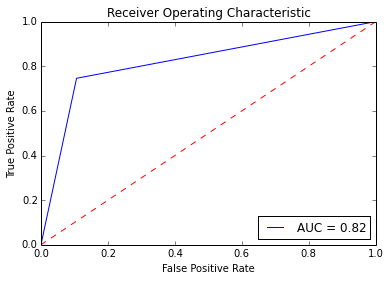

0.809090909091
(array([ 0.        ,  0.10638298,  1.        ]), array([ 0.        ,  0.74603175,  1.        ]))


In [103]:
grid_sgd = SGDClassifier(loss='hinge',
                         n_jobs=-1,
                         penalty='l2',
                         random_state=0)
grid_sgd.fit(X_train_std, y_train)
plot_roc_curve(grid_sgd, X_test_std, y_test)

## Nearest Centroid Classifier

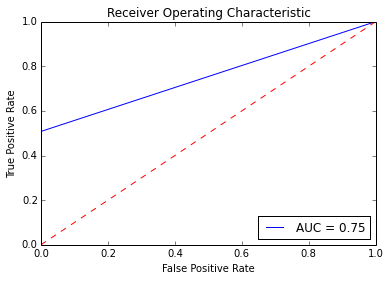

0.718181818182
(array([ 0.,  1.]), array([ 0.50793651,  1.        ]))


In [95]:
ncc = NearestCentroid()
ncc.fit(X_train, y_train)
plot_roc_curve(ncc, X_test, y_test)

## AdaBoost

In [ ]:
# hyperparameters = [{
#         'learning_rate': [.01, .1, .5, 1, 10],
#         'n_estimators': [10, 50, 100],
# }]
# grid_adaboost = GridSearchCV(AdaBoostClassifier(random_state=0),
#                              param_grid=hyperparameters,
#                              verbose=True)
# grid_adaboost.fit(X_train, y_train)
# grid_adaboost = grid_adaboost.best_estimator_
# print(grid_adaboost)
# grid_adaboost.score(X_test, y_test)

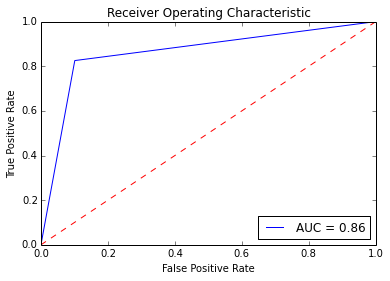

0.856818181818
(array([ 0.        ,  0.10106383,  1.        ]), array([ 0.        ,  0.82539683,  1.        ]))


In [96]:
grid_adaboost = \
    AdaBoostClassifier(algorithm='SAMME.R',
                       base_estimator=None,
                       learning_rate=0.5,
                       n_estimators=50,
                       random_state=0)
grid_adaboost.fit(X_train, y_train)
plot_roc_curve(grid_adaboost, X_test, y_test)

## Logistic Regression

In [ ]:
# hyperparameters = [{
#         'penalty': ['l1', 'l2'],
#         'C': [.01, .1, 1, 10],
# }]
# grid_lr = GridSearchCV(LogisticRegression(n_jobs=-1, random_state=0),
#                        param_grid=hyperparameters,
#                        verbose=True)
# grid_lr.fit(X_train_std, y_train)
# grid_lr = grid_lr.best_estimator_
# print(grid_lr)
# grid_lr.score(X_test_std, y_test)

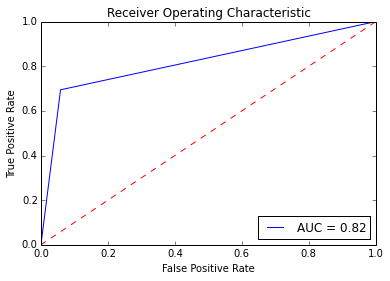

0.8
(array([ 0.        ,  0.05851064,  1.        ]), array([ 0.        ,  0.69444444,  1.        ]))


In [100]:
grid_lr = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
grid_lr.fit(X_train_std, y_train)
plot_roc_curve(grid_lr, X_test_std, y_test)

## LinearDiscriminantAnalysis

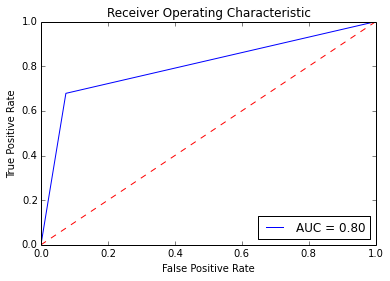

0.784090909091
(array([ 0.        ,  0.07446809,  1.        ]), array([ 0.        ,  0.67857143,  1.        ]))


In [98]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
plot_roc_curve(lda, X_test, y_test)

## Testing

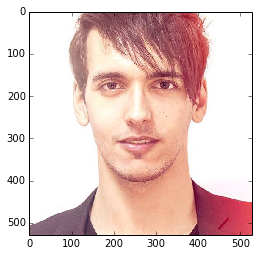

In [88]:
from matplotlib import pyplot as plt

image = imread('/Users/irio/Desktop/bruno_original.jpg')
plt.imshow(image, interpolation='nearest')
plt.show()

In [210]:
paths = [
#     '/Users/irio/Desktop/bruno.jpg',
#     '/Users/Irio/Desktop/r0a3c52a0t_tempered.jpg',
#     '/Users/Irio/Desktop/funny-photoshop-pictures.jpg',
#     '/Users/Irio/Desktop/funny_photoshopped_picture_303.jpg',
#     '/Users/Irio/Desktop/Funny-Photoshopped-80.jpg',
#     '/Users/Irio/Desktop/IMG_2663.jpg',
#     '/Users/irio/Desktop/IMG_2515.jpg',
#     '/Users/irio/Desktop/IMG_2667.jpg',
#     '/Users/irio/Desktop/VTHOf2G.jpg',
#     '/Users/irio/Desktop/CVxmbs3.jpg',
    '/Users/irio/Desktop/z0UvSRi.jpg',
    '/Users/irio/Desktop/XcUwEVX.jpg',
]
test2_y = np.r_[1, 0]

test2 = list(map(read_image, paths))
test2_std = standardizer.fit_transform(test2)

# models = [grid_random_forest, grid_svc, ncc, grid_adaboost, lda]
models = [grid_random_forest, grid_svc, grid_adaboost, lda]
linear_models = [grid_lr, grid_sgd]
# print(map(lambda model: model.predict(test2), models))
# print(map(lambda model: model.predict(test2_std), linear_models))

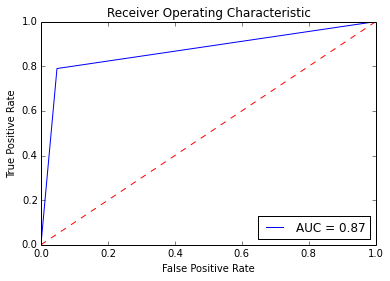

0.859090909091
(array([ 0.        ,  0.04787234,  1.        ]), array([ 0.        ,  0.78968254,  1.        ]))


In [136]:
pipeline = [
    ('random_forest', grid_random_forest),
#     ('ncc', ncc),
#     ('lda', lda),
#     ('grid_adaboost', grid_adaboost),
    ('logistic_regression', grid_lr),
#     ('sgd', grid_sgd),
]
voting_ensemble = VotingClassifier(pipeline, voting='soft')
# voting_ensemble = VotingClassifier(pipeline, voting='hard')
voting_ensemble.fit(X_train_std, y_train)
plot_roc_curve(voting_ensemble, X_test_std, y_test)

In [159]:
print(voting_ensemble.predict_proba(test2))
print(tree_ensemble.predict_proba(test2))
print(grid_random_forest.predict_proba(test2))

[[  0.00000000e+00   1.00000000e+00]
 [  0.00000000e+00   1.00000000e+00]
 [  3.29003713e-10   1.00000000e+00]
 [  0.00000000e+00   1.00000000e+00]
 [  0.00000000e+00   1.00000000e+00]
 [  0.00000000e+00   1.00000000e+00]
 [  0.00000000e+00   1.00000000e+00]
 [  0.00000000e+00   1.00000000e+00]]
[[ 0.45105263  0.54894737]
 [ 0.55984109  0.44015891]
 [ 0.6717788   0.3282212 ]
 [ 0.45007932  0.54992068]
 [ 0.19358143  0.80641857]
 [ 0.32874085  0.67125915]
 [ 0.37797172  0.62202828]
 [ 0.2527728   0.7472272 ]]
[[ 0.4   0.6 ]
 [ 0.6   0.4 ]
 [ 0.85  0.15]
 [ 0.4   0.6 ]
 [ 0.    1.  ]
 [ 0.2   0.8 ]
 [ 0.3   0.7 ]
 [ 0.1   0.9 ]]


In [150]:
print(tree_ensemble.predict(test2))

[1 0 1 1]


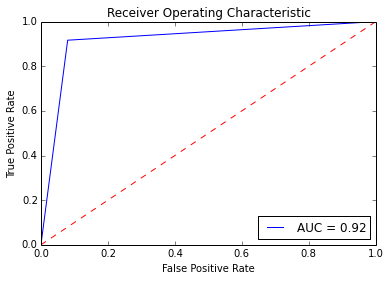

0.918181818182
(array([ 0.        ,  0.07978723,  1.        ]), array([ 0.        ,  0.91666667,  1.        ]))


In [194]:
tree_pipeline = [
    ('random_forest', grid_random_forest),
    ('grid_adaboost', grid_adaboost),
]
tree_ensemble = VotingClassifier(tree_pipeline, voting='soft')
tree_ensemble.fit(X_train, y_train)
plot_roc_curve(tree_ensemble, X_test, y_test)

In [211]:
print(map(lambda model: model.score(test2, test2_y),
          models + [voting_ensemble, tree_ensemble]))

[0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


In [212]:
print(tree_ensemble.score(test2, test2_y))
print(tree_ensemble.predict(test2))
print(tree_ensemble.predict_proba(test2))

0.5
[1 1]
[[ 0.19022705  0.80977295]
 [ 0.27045037  0.72954963]]
